## Analyze A/B Test Results

A/B tests are commonly performed by data analysts and data scientists. Therefore, it is important to practice these analyses. For this project the results of an A/B test completed by an e-commerce website is considered. The goal is to help the company understand if they should implement the new page, keep the old page, or run the experiment longer before making their decision.

## Table of Contents
- [Introduction](#introduction)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)

<a id='introduction'></a>
#### Introduction
##### Install Anaconda, open terminal, and isolate project in its own environment.

`~ $ conda create -n proj4 ... create a new environment to isolate project dependencies`

`~ $ source activate proj4 ... enter environment`

`~ $ conda install python=3 numpy pandas matplotlib statsmodels ... install required packages`

`~ $ conda env export > environment.yaml ... write project dependencies to conda specific file`

`~ $ pip freeze > requirements.txt ... write project dependencies to generic file`

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
# import packages
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

# 'magic keyword' with % symbol interacts with this notebook
# plot inline with cells rather than a separate window
% matplotlib inline

# set the random seed to assure repeatability of results
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.

a. Take a look at the top few rows.

In [2]:
# import dataset in dataframe object
df = pd.read_csv('ab_data.csv')

In [3]:
# print df
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Find the number of rows in the dataset.

In [4]:
# number of rows
df.shape[0]

294478

c. The number of unique users in the dataset.

In [5]:
# number of unique users
unique_users = df.user_id.nunique()
unique_users

290584

d. The proportion of users converted.

In [6]:
# proportion of users converted
unique_user_conversions = df.user_id[(df.converted == 1)].nunique()
prop_conversions = unique_user_conversions / unique_users
prop_conversions

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't line up.

In [7]:
# group classifications
df.group.unique()

array(['control', 'treatment'], dtype=object)

In [8]:
# landing page classifications
df.landing_page.unique()

array(['old_page', 'new_page'], dtype=object)

In [9]:
# number of times 'new_page' and 'treatment' do not align
# two scenarios where this occurs
control_new_page = df[(df.group == 'control') & (df.landing_page == 'new_page')]
treatment_old_page = df[(df.group == 'treatment') & (df.landing_page == 'old_page')]

# add the occurances of both scenarios together
control_new_page.shape[0] + treatment_old_page.shape[0]

3893

f. Do any of the rows have missing values?

In [10]:
# identify null values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

**None of the rows have missing values.**

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. Store your new dataframe in **df2**.

In [11]:
# define the index of each df subset as the timestamp column
control_new_page.set_index('timestamp')
treatment_old_page.set_index('timestamp');

In [12]:
# create df2 by dropping a subset out of df
df2 = df.drop(index = control_new_page.index)

# further refine df2 by dropping a subset out of itself
df2 = df2.drop(index = treatment_old_page.index)

In [13]:
# double check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to continue the analysis.

a. How many unique **user_id**s are in **df2**?

In [14]:
# number of unique users
unique_users = df2.user_id.nunique()
unique_users

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [15]:
# create a boolean mask to isolate the duplicate user_id row
mask = df2.user_id.duplicated()
df2.user_id[mask]

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [16]:
# full rows for the duplicate user_id
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [17]:
# remove one of the duplicate rows (default is first duplicate occurance at row 2893)
df2.drop_duplicates(subset = 'user_id', inplace=True)

In [18]:
# row 2893 has been removed
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


`4.` Use **df2** in the below cells to continue the analysis.

a. What is the probability of an individual converting regardless of the page they receive?

In [19]:
# converstion rate regardless of any feature
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [20]:
# conversion rate of control group
full_p_old = df2.converted[df2.group == 'control'].mean()
full_p_old

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [21]:
# conversion rate of treatment group
full_p_new = df2.converted[df2.group == 'treatment'].mean()
full_p_new

0.11880806551510564

d. What is the probability that an individual received the new page?

In [22]:
# proportion of users who viewed the new landing page
(df2.landing_page == 'new_page').mean()

0.50006194422266881

e. Is there evidence that one page leads to more conversions?

**50.0% of the dataset received the new landing page as the treatment group, and the other 50.0% was the control group. The treatment group's conversion rate with the new page was 11.9%, while the control group with the old page converted at 12.0%. These rates are within 0.1%, indicating at first glance there is no significant evidence either landing page is better.**

<a id='ab_test'></a>
### Part II - A/B Test

Due to the time stamp associated with each event, it is possible to run a hypothesis test continuously for each observation. However, when do we stop ... as soon as one page is considered significantly better than another, or does it need to happen consistently for a certain amount of time? How long do we continue to render a decision that neither page is better than another? In general, these questions are the difficult trades associated with A/B tests.

`1.` For now, consider the decision must be made only with the data provided. Assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%. What should the null and alternative hypotheses be?  State the hypothesis in terms of $p_{old}$ and $p_{new}$, which are defined as the converted rates for the old and new pages.

**$H_0: p_{old} >= p_{new}$**

**$H_1: p_{old} < p_{new}$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in `ab_data.csv` regardless of the page. <br><br>

Use a sample size for each page equal to the ones in `ab_data.csv`. Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null. Use the cells below to provide the necessary parts of this simulation.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [23]:
# assume p_new is equal to the conversion rate regardless of landing page
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [24]:
# assume p_old = p_new for this null
p_old = p_new
p_old

0.11959708724499628

c. What is $n_{new}$?

In [25]:
# total occurances of the new landing page
n_new = (df2.landing_page == 'new_page').sum()
n_new

145310

d. What is $n_{old}$?

In [26]:
# total occurances of the old landing page
n_old = (df2.landing_page == 'old_page').sum()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [27]:
# choose either 0 or 1 with a probability of p_new, a total of n_new times
new_page_converted = np.random.choice([0, 1], size = n_new, p = [1 - p_new, p_new])
p_new_sim = new_page_converted.mean()

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [28]:
# choose either 0 or 1 with a probability of p_old, a total of n_old times
old_page_converted = np.random.choice([0, 1], size = n_old, p = [1 - p_old, p_old])
p_old_sim = old_page_converted.mean()

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [29]:
# subtract the simulated values for p_old from p_new
diff = p_new_sim - p_old_sim
diff

0.0018424902461277731

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [30]:
# same logic above encapulated in a loop with 10000 iterations
# this will create a sampling distribution without bootstraping
# for the difference in page conversions under the null assumption H0: p_new = p_old
p_diffs = []
for _ in range(10000):
    
    # choose either 0 or 1 with a probability of p_new (= p_old), a total of n_new (or n_old) times
    new_page_converted = np.random.choice([0, 1], size = n_new, p = [1 - p_new, p_new])
    old_page_converted = np.random.choice([0, 1], size = n_old, p = [1 - p_old, p_old])

    # probability of conversions
    p_new_sim = new_page_converted.mean()
    p_old_sim = old_page_converted.mean()
    
    # compute difference in means
    p_diffs.append(p_new_sim - p_old_sim)

i. Plot a histogram of the **p_diffs**. Does this plot have the expected shape?

In [31]:
# convert python list to numpy array
p_diffs = np.array(p_diffs)

In [32]:
# actual value of statistic from full dataset
full_diff = full_p_new - full_p_old
full_diff

-0.0015782389853555567

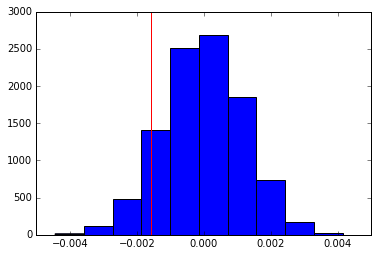

In [33]:
# plot histogram of null distribution
plt.hist(p_diffs);

# plot actual statistic over null distribution
plt.axvline(x = full_diff, color = 'red');

**This is a normal distribution of the simulated null hypothesis. Since the null hypothesis is that the two page conversion rates are equal, the difference between them is zero, and the distribution mean is therefore zero. The actual statistic from the data is slightly left of the mean at -0.00158. Although this is a few standard deviations from the mean at zero, it is plausible that this statistic came from the null hypothesis, and therefore we will not reject $H_0$.**

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [34]:
# region from the red line to the extereme right side of the distribution
upper_region = (p_diffs > full_diff).mean()

# p-value = total shaded region
p_value = upper_region
p_value

0.90839999999999999

k. In words, explain what was computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**This is the p-value. The p-value is the probability of observing a statistic of interest, or one more extreme, given that the null hypothesis is true. To represent the null hypothesis, a normal distribution with mean of zero and standard deviation equal to the standard deviation of the original sample is plotted. The observed statistic, in this case the difference in mean conversion rates of the two pages, is placed on this plot. The statistic falls a few standard deviations to left of the mean, and since our alternate hypothesis $H_1: p_{new} - p_{old} > 0$, the p-value encompasses the region to the right of this line, almost the entire distribution. In other words, we fail to reject the null hypothesis as p-value = 0.91 is much greater than our Type I Error threshold of $\alpha = 0.05$.**

l. We could also use a built-in function to achieve similar results. Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the number of rows associated with the old page and new pages, respectively.

In [35]:
# import statistics package
import statsmodels.api as sm

# total number of conversions in the dataset
convert_old = df2.converted[df.landing_page == 'old_page'].sum()
convert_new = df2.converted[df.landing_page == 'new_page'].sum()
# n_old and n_new were calculated previously

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [36]:
# calculate p-value and z-score using built-in
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')

In [37]:
# print results to notebook
p_value, z_score

(0.90505831275902449, -1.3109241984234394)

n. What do the z-score and p-value mean for the conversion rates of the old and new pages? Do they agree with the findings in parts **j.** and **k.**?

**The p-value obtained by proportions_ztest() is very similar to that obtained by direct simulation of the null hypothesis. Since the p-value >> $\alpha$ we fail to reject the null hypothesis. The z-score indicates the number of standard deviations the statistic is from the null hypothesis mean. As shown by the red line in the plot above, the statistic is -1.31 standard deviations from the null hypothesis mean of zero. The output of the built-in function matches the direct simulation results.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, the result achieved in the previous A/B test will also be achieved by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**logistic regression**

b. The goal is to use `statsmodels` to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, first we need to create a column for the intercept, and a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [38]:
# check dataset
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [39]:
# column for the intercept with an arbitrary value
df2['intercept'] = 1

In [40]:
# dummy variables for the landing_page feature
df2[['old_page', 'ab_page']] = pd.get_dummies(df['group'])

In [41]:
# check dataset
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,old_page,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


In [42]:
# remove unessecary columns
df2.drop(['group', 'landing_page', 'old_page'], axis = 1, inplace = True)

c. Use **statsmodels** to import the regression model.  Instantiate the model, and fit the model using the two columns created in part **b.** to predict whether or not an individual converts.

In [43]:
# define the response y vector
y = df2['converted']

In [44]:
# define the predictor X matrix
X = df2[['intercept', 'ab_page']]

In [45]:
# create a logistic regression using statsmodels
log_model = sm.Logit(y, X)

In [46]:
# fit the model
fit = log_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of the model.

In [47]:
# print summary of regression parameters
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 28 Sep 2018   Pseudo R-squ.:               8.077e-06
Time:                        15:24:01   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value found in **Part II**? What are the null and alternative hypotheses associated with the regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**The p-value associated with the landing page is 0.190, which is greater than the Type I Error threshold of $\alpha$ = 0.05. Therefore, we again fail to reject the null hypothesis. The null hypothesis of a $\beta$ coefficient in logistic regression is that the variable does not have a statistically signficant effect on the odds of response occuring, holding all other variables constant. In this case, $H_1$ is that the landing page the user observes changes the odds that they will convert, holding all other variables constant. With p-value > $\alpha$ we conclude that $H_0$ is true; that the type of landing page does not have a significant effect on user conversion, holding all other variables constant.**

f. Now, consider other influences on individual converions.  Discuss why it is a good idea to consider other factors to add into the regression model.  Are there any disadvantages to adding additional terms into the regression model?

**In general, a scientific model should include all factors that have significant influence on the response ... and nothing else. In other words, the model should have the bare minimum complexity in order to adequately describe the event. We can consider other factors if there is reason to believe the explanatory and response variables are related in more complicated ways, for example a quadratic, cubic, interaction, etc. Including these higher order terms destroys the intuitive representation of the $\beta$ coefficients. The intuitive explanations of these coefficients are valuable with respect to understanding the data and communicating the results. Without clear evidence of a higher order relationship the coefficients should remain against simple linear single variables in the logistic regression equations.**

g. Along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. Read in the `countries.csv` dataset and merge together the datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion? Provide the statistical output as well as a written response to answer this question.

In [48]:
# import table of countries
df_c = pd.read_csv('countries.csv')

In [49]:
# check dataset
df_c.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [50]:
# check dataset
df2.head()

,user_id,timestamp,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,0,1,0
1,804228,2017-01-12 08:01:45.159739,0,1,0
2,661590,2017-01-11 16:55:06.154213,0,1,1
3,853541,2017-01-08 18:28:03.143765,0,1,1
4,864975,2017-01-21 01:52:26.210827,1,1,0


In [51]:
# set a common index, then merge this country column into df2
df2.set_index('user_id', inplace = True)
df_c.set_index('user_id', inplace = True)
df2 = df2.join(df_c)

In [52]:
# create dummies from categorical variable 'country'
country_dummies = pd.get_dummies(df2['country'])

In [53]:
# add these dummies into df2
df2 = df2.join(country_dummies);

In [54]:
# remove unessecary columns
df2.drop(['UK', 'country'], axis = 1, inplace = True)

In [55]:
# check dataset
df2.head()

,timestamp,converted,intercept,ab_page,CA,US
user_id,,,,,,
851104,2017-01-21 22:11:48.556739,0,1,0,0,1
804228,2017-01-12 08:01:45.159739,0,1,0,0,1
661590,2017-01-11 16:55:06.154213,0,1,1,0,1
853541,2017-01-08 18:28:03.143765,0,1,1,0,1
864975,2017-01-21 01:52:26.210827,1,1,0,0,1


In [56]:
# define the response y vector
y = df2['converted']

In [57]:
# define the predictor X matrix
X = df2[['intercept', 'ab_page', 'CA', 'US']]

In [58]:
# create a logistic regression using statsmodels
log_model = sm.Logit(y, X)

In [59]:
# fit the model
fit = log_model.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [60]:
# print summary of regression parameters
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 28 Sep 2018   Pseudo R-squ.:               2.323e-05
Time:                        15:24:03   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9794      0.013   -155.415      0.000      -2.004      -1.954
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0506      0.028     -1.784      0.074      -0.106       0.005
US            -0.0099      0.013     -0.743      0.457      -0.036       0.016
==============================================================================
"""

**All the p-values for the countries (and one state) are less than $\alpha$ = 0.05. Therefore, the user's location does not have a statistically significant effect on whether or not they convert. However, the coefficient for CA has a p-value of 0.074.**

**Note: If the Type I Error rate for this analysis were relaxed, for example to $\alpha$ = 0.1, then the following statement would be true: A user located in CA is 1/exp(-0.0506) = 1.05 = 5% less likely to convert than a user from the UK, keeping the landing page constant.**

h. Consider an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results and conclusions based on the results.

In [61]:
# check dataset
df2.head()

,timestamp,converted,intercept,ab_page,CA,US
user_id,,,,,,
851104,2017-01-21 22:11:48.556739,0,1,0,0,1
804228,2017-01-12 08:01:45.159739,0,1,0,0,1
661590,2017-01-11 16:55:06.154213,0,1,1,0,1
853541,2017-01-08 18:28:03.143765,0,1,1,0,1
864975,2017-01-21 01:52:26.210827,1,1,0,0,1


In [62]:
# define columns for the interaction of country and landing page
df2['ab_page*CA'] = df2.ab_page*df2.CA
df2['ab_page*US'] = df2.ab_page*df2.US

In [63]:
# check dataset
df2.head()

,timestamp,converted,intercept,ab_page,CA,US,ab_page*CA,ab_page*US
user_id,,,,,,,,
851104,2017-01-21 22:11:48.556739,0,1,0,0,1,0,0
804228,2017-01-12 08:01:45.159739,0,1,0,0,1,0,0
661590,2017-01-11 16:55:06.154213,0,1,1,0,1,0,1
853541,2017-01-08 18:28:03.143765,0,1,1,0,1,0,1
864975,2017-01-21 01:52:26.210827,1,1,0,0,1,0,0


In [64]:
# define the response y vector
y = df2['converted']

In [65]:
# define the predictor X matrix
X = df2[['intercept', 'ab_page', 'CA', 'US', 'ab_page*CA', 'ab_page*US']]

In [66]:
# create a logistic regression using statsmodels
log_model = sm.Logit(y, X)

In [67]:
# fit the model
fit = log_model.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [68]:
# print summary of regression parameters
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Fri, 28 Sep 2018   Pseudo R-squ.:               3.482e-05
Time:                        15:24:06   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9922      0.016   -123.457      0.000      -2.024      -1.961
ab_page        0.0108      0.023      0.475      0.635      -0.034       0.056
CA            -0.0118      0.040     -0.296      0.767      -0.090       0.066
US             0.0057      0.019      0.306      0.760      -0.031       0.043
ab_page*CA    -0.0783      0.057     -1.378      0.168      -0.190       0.033
ab_page*US    -0.0314      0.027     -1.181      0.238      -0.084       0.021
==============================================================================
"""

**The interaction term has still not produced a statistically significant result as p-values for all regression terms are less than the Type I Error threshold $\alpha$ = 0.05. The conversion rates of the two websites are so closely aligned that it is difficult to find a valid predictor variable.**

In [69]:
# total experiment time
min(df2.timestamp), max(df2.timestamp)

('2017-01-02 13:42:05.378582', '2017-01-24 13:41:54.460509')

<a id='conclusions'></a>
## Conclusion

**The new landing page does not have a statistically significant affect on user conversion rate. Virtually no change is observed between the conversion rates of the old and new websites. This A/B test was conducted for 22 days in January 2017. If a decision must be made now, the recommendation is to continue with the existing website. Running the experiment for a longer duration (for example three months) may provide statistically significant patterns that are hidden in the rather short length of the current experiment.**

In [70]:
# convert notebook to HTML for universal sharing ...
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0